In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 1]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
    for i in range(2, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [4]:
data_df = pd.read_csv('../../../_data/Tavares2017.csv')
data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 2 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)
data_df['sbj'] += 1

data_df['Right Value - Left Value'] = data_df['item_value_1'] - data_df['item_value_0']

data_df['gaze diff'] = data_df['gaze_1'] - data_df['gaze_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - L)'] = mms.fit_transform(data_df[['gaze diff']])


min_rt = data_df.groupby(by='sbj')['rt'].min()

In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.4)

obs_train = np.asarray(tr_df[['rt', 'choice']])
X_train = np.asarray(tr_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1']])

obs_test = np.asarray(ts_df[['rt', 'choice']])
X_test = np.asarray(ts_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1']])

print(X_train.shape, X_test.shape)

(18269, 4) (12195, 4)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 87        
                                                                 
Total params: 380 (1.48 KB)
Trainable params: 380 (1.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3000)

Epoch 1/3000
1/1 [==============================] - 687s 687s/step - loss: 97832.0703
Epoch 2/3000
1/1 [==============================] - 0s 182ms/step - loss: 97376.6406
Epoch 3/3000
1/1 [==============================] - 0s 126ms/step - loss: 97051.1484
Epoch 4/3000
1/1 [==============================] - 0s 115ms/step - loss: 96778.8672
Epoch 5/3000
1/1 [==============================] - 0s 114ms/step - loss: 96537.2500
Epoch 6/3000
1/1 [==============================] - 0s 117ms/step - loss: 96316.0000
Epoch 7/3000
1/1 [==============================] - 0s 145ms/step - loss: 96109.4219
Epoch 8/3000
1/1 [==============================] - 0s 113ms/step - loss: 95913.9531
Epoch 9/3000
1/1 [==============================] - 0s 112ms/step - loss: 95727.2031
Epoch 10/3000
1/1 [==============================] - 0s 114ms/step - loss: 95547.4844
Epoch 11/3000
1/1 [==============================] - 0s 113ms/step - loss: 95373.5391
Epoch 12/3000
1/1 [==============================] - 0s 112ms/

1/1 [==============================] - 0s 160ms/step - loss: 85863.1719
Epoch 97/3000
1/1 [==============================] - 0s 159ms/step - loss: 85783.7891
Epoch 98/3000
1/1 [==============================] - 0s 165ms/step - loss: 85704.9375
Epoch 99/3000
1/1 [==============================] - 0s 168ms/step - loss: 85626.5938
Epoch 100/3000
1/1 [==============================] - 0s 171ms/step - loss: 85548.7812
Epoch 101/3000
1/1 [==============================] - 0s 166ms/step - loss: 85471.4688
Epoch 102/3000
1/1 [==============================] - 0s 164ms/step - loss: 85394.6641
Epoch 103/3000
1/1 [==============================] - 0s 167ms/step - loss: 85318.3594
Epoch 104/3000
1/1 [==============================] - 0s 169ms/step - loss: 85242.5312
Epoch 105/3000
1/1 [==============================] - 0s 168ms/step - loss: 85167.2031
Epoch 106/3000
1/1 [==============================] - 0s 166ms/step - loss: 85092.3516
Epoch 107/3000
1/1 [==============================] - 0s 166m

1/1 [==============================] - 0s 176ms/step - loss: 80096.5781
Epoch 191/3000
1/1 [==============================] - 0s 176ms/step - loss: 80048.7656
Epoch 192/3000
1/1 [==============================] - 0s 172ms/step - loss: 80001.1562
Epoch 193/3000
1/1 [==============================] - 0s 170ms/step - loss: 79953.7500
Epoch 194/3000
1/1 [==============================] - 0s 165ms/step - loss: 79906.5391
Epoch 195/3000
1/1 [==============================] - 0s 169ms/step - loss: 79859.5312
Epoch 196/3000
1/1 [==============================] - 0s 168ms/step - loss: 79812.7344
Epoch 197/3000
1/1 [==============================] - 0s 165ms/step - loss: 79766.1250
Epoch 198/3000
1/1 [==============================] - 0s 167ms/step - loss: 79719.7031
Epoch 199/3000
1/1 [==============================] - 0s 167ms/step - loss: 79673.4844
Epoch 200/3000
1/1 [==============================] - 0s 164ms/step - loss: 79627.4531
Epoch 201/3000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 166ms/step - loss: 76305.5000
Epoch 285/3000
1/1 [==============================] - 0s 165ms/step - loss: 76270.4453
Epoch 286/3000
1/1 [==============================] - 0s 164ms/step - loss: 76235.2812
Epoch 287/3000
1/1 [==============================] - 0s 166ms/step - loss: 76199.9062
Epoch 288/3000
1/1 [==============================] - 0s 165ms/step - loss: 76164.2656
Epoch 289/3000
1/1 [==============================] - 0s 168ms/step - loss: 76128.2266
Epoch 290/3000
1/1 [==============================] - 0s 165ms/step - loss: 76091.6875
Epoch 291/3000
1/1 [==============================] - 0s 166ms/step - loss: 76054.5625
Epoch 292/3000
1/1 [==============================] - 0s 165ms/step - loss: 76016.7500
Epoch 293/3000
1/1 [==============================] - 0s 166ms/step - loss: 75978.2031
Epoch 294/3000
1/1 [==============================] - 0s 166ms/step - loss: 75938.9219
Epoch 295/3000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 177ms/step - loss: 72034.9688
Epoch 379/3000
1/1 [==============================] - 0s 169ms/step - loss: 71992.7031
Epoch 380/3000
1/1 [==============================] - 0s 171ms/step - loss: 71950.5469
Epoch 381/3000
1/1 [==============================] - 0s 169ms/step - loss: 71908.4844
Epoch 382/3000
1/1 [==============================] - 0s 164ms/step - loss: 71866.5156
Epoch 383/3000
1/1 [==============================] - 0s 169ms/step - loss: 71824.6484
Epoch 384/3000
1/1 [==============================] - 0s 163ms/step - loss: 71782.8672
Epoch 385/3000
1/1 [==============================] - 0s 165ms/step - loss: 71741.1875
Epoch 386/3000
1/1 [==============================] - 0s 162ms/step - loss: 71699.5859
Epoch 387/3000
1/1 [==============================] - 0s 163ms/step - loss: 71658.0781
Epoch 388/3000
1/1 [==============================] - 0s 162ms/step - loss: 71616.6641
Epoch 389/3000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 167ms/step - loss: 68308.3594
Epoch 473/3000
1/1 [==============================] - 0s 161ms/step - loss: 68268.9531
Epoch 474/3000
1/1 [==============================] - 0s 162ms/step - loss: 68229.9062
Epoch 475/3000
1/1 [==============================] - 0s 161ms/step - loss: 68190.5391
Epoch 476/3000
1/1 [==============================] - 0s 166ms/step - loss: 68151.5625
Epoch 477/3000
1/1 [==============================] - 0s 161ms/step - loss: 68112.2422
Epoch 478/3000
1/1 [==============================] - 0s 162ms/step - loss: 68073.3203
Epoch 479/3000
1/1 [==============================] - 0s 165ms/step - loss: 68034.0781
Epoch 480/3000
1/1 [==============================] - 0s 165ms/step - loss: 67995.2266
Epoch 481/3000
1/1 [==============================] - 0s 166ms/step - loss: 67956.0391
Epoch 482/3000
1/1 [==============================] - 0s 161ms/step - loss: 67917.2656
Epoch 483/3000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 171ms/step - loss: 63336.9219
Epoch 567/3000
1/1 [==============================] - 0s 173ms/step - loss: 63251.0859
Epoch 568/3000
1/1 [==============================] - 0s 167ms/step - loss: 63167.0938
Epoch 569/3000
1/1 [==============================] - 0s 168ms/step - loss: 63084.4961
Epoch 570/3000
1/1 [==============================] - 0s 167ms/step - loss: 63003.7734
Epoch 571/3000
1/1 [==============================] - 0s 164ms/step - loss: 62924.3398
Epoch 572/3000
1/1 [==============================] - 0s 164ms/step - loss: 62846.6602
Epoch 573/3000
1/1 [==============================] - 0s 166ms/step - loss: 62770.0625
Epoch 574/3000
1/1 [==============================] - 0s 165ms/step - loss: 62695.0000
Epoch 575/3000
1/1 [==============================] - 0s 165ms/step - loss: 62620.7734
Epoch 576/3000
1/1 [==============================] - 0s 167ms/step - loss: 62547.8516
Epoch 577/3000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 166ms/step - loss: 58569.8242
Epoch 661/3000
1/1 [==============================] - 0s 169ms/step - loss: 58531.6016
Epoch 662/3000
1/1 [==============================] - 0s 172ms/step - loss: 58493.6719
Epoch 663/3000
1/1 [==============================] - 0s 164ms/step - loss: 58455.6523
Epoch 664/3000
1/1 [==============================] - 0s 166ms/step - loss: 58417.7969
Epoch 665/3000
1/1 [==============================] - 0s 163ms/step - loss: 58379.8984
Epoch 666/3000
1/1 [==============================] - 0s 164ms/step - loss: 58342.1680
Epoch 667/3000
1/1 [==============================] - 0s 169ms/step - loss: 58304.4609
Epoch 668/3000
1/1 [==============================] - 0s 165ms/step - loss: 58266.9922
Epoch 669/3000
1/1 [==============================] - 0s 167ms/step - loss: 58229.5391
Epoch 670/3000
1/1 [==============================] - 0s 163ms/step - loss: 58192.3516
Epoch 671/3000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 170ms/step - loss: 55266.0938
Epoch 755/3000
1/1 [==============================] - 0s 168ms/step - loss: 55231.9883
Epoch 756/3000
1/1 [==============================] - 0s 166ms/step - loss: 55198.4531
Epoch 757/3000
1/1 [==============================] - 0s 168ms/step - loss: 55165.4570
Epoch 758/3000
1/1 [==============================] - 0s 168ms/step - loss: 55133.6250
Epoch 759/3000
1/1 [==============================] - 0s 168ms/step - loss: 55102.1250
Epoch 760/3000
1/1 [==============================] - 0s 170ms/step - loss: 55070.3984
Epoch 761/3000
1/1 [==============================] - 0s 167ms/step - loss: 55036.5742
Epoch 762/3000
1/1 [==============================] - 0s 166ms/step - loss: 55002.8711
Epoch 763/3000
1/1 [==============================] - 0s 170ms/step - loss: 54969.2031
Epoch 764/3000
1/1 [==============================] - 0s 168ms/step - loss: 54936.3203
Epoch 765/3000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 163ms/step - loss: 52558.1719
Epoch 849/3000
1/1 [==============================] - 0s 167ms/step - loss: 52533.8359
Epoch 850/3000
1/1 [==============================] - 0s 165ms/step - loss: 52509.2148
Epoch 851/3000
1/1 [==============================] - 0s 168ms/step - loss: 52485.1055
Epoch 852/3000
1/1 [==============================] - 0s 167ms/step - loss: 52460.6406
Epoch 853/3000
1/1 [==============================] - 0s 164ms/step - loss: 52436.6641
Epoch 854/3000
1/1 [==============================] - 0s 163ms/step - loss: 52412.2969
Epoch 855/3000
1/1 [==============================] - 0s 169ms/step - loss: 52388.4492
Epoch 856/3000
1/1 [==============================] - 0s 168ms/step - loss: 52364.1992
Epoch 857/3000
1/1 [==============================] - 0s 167ms/step - loss: 52340.4883
Epoch 858/3000
1/1 [==============================] - 0s 168ms/step - loss: 52316.3711
Epoch 859/3000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 168ms/step - loss: 50571.0898
Epoch 943/3000
1/1 [==============================] - 0s 169ms/step - loss: 50553.4219
Epoch 944/3000
1/1 [==============================] - 0s 168ms/step - loss: 50534.9062
Epoch 945/3000
1/1 [==============================] - 0s 169ms/step - loss: 50516.8125
Epoch 946/3000
1/1 [==============================] - 0s 163ms/step - loss: 50498.3203
Epoch 947/3000
1/1 [==============================] - 0s 170ms/step - loss: 50480.7109
Epoch 948/3000
1/1 [==============================] - 0s 167ms/step - loss: 50462.8477
Epoch 949/3000
1/1 [==============================] - 0s 167ms/step - loss: 50446.0898
Epoch 950/3000
1/1 [==============================] - 0s 165ms/step - loss: 50428.5000
Epoch 951/3000
1/1 [==============================] - 0s 170ms/step - loss: 50411.8125
Epoch 952/3000
1/1 [==============================] - 0s 167ms/step - loss: 50393.5352
Epoch 953/3000
1/1 [==============================] - 0s 1

Epoch 1036/3000
1/1 [==============================] - 0s 168ms/step - loss: 49097.3281
Epoch 1037/3000
1/1 [==============================] - 0s 169ms/step - loss: 49084.3516
Epoch 1038/3000
1/1 [==============================] - 0s 167ms/step - loss: 49070.8984
Epoch 1039/3000
1/1 [==============================] - 0s 170ms/step - loss: 49057.6836
Epoch 1040/3000
1/1 [==============================] - 0s 164ms/step - loss: 49044.0234
Epoch 1041/3000
1/1 [==============================] - 0s 164ms/step - loss: 49030.4844
Epoch 1042/3000
1/1 [==============================] - 0s 172ms/step - loss: 49016.7188
Epoch 1043/3000
1/1 [==============================] - 0s 167ms/step - loss: 49003.4922
Epoch 1044/3000
1/1 [==============================] - 0s 169ms/step - loss: 48990.0312
Epoch 1045/3000
1/1 [==============================] - 0s 213ms/step - loss: 48977.5664
Epoch 1046/3000
1/1 [==============================] - 0s 170ms/step - loss: 48964.2031
Epoch 1047/3000
1/1 [===========

1/1 [==============================] - 0s 166ms/step - loss: 47988.2188
Epoch 1130/3000
1/1 [==============================] - 0s 169ms/step - loss: 47977.7109
Epoch 1131/3000
1/1 [==============================] - 0s 168ms/step - loss: 47967.6992
Epoch 1132/3000
1/1 [==============================] - 0s 166ms/step - loss: 47957.3633
Epoch 1133/3000
1/1 [==============================] - 0s 167ms/step - loss: 47946.9844
Epoch 1134/3000
1/1 [==============================] - 0s 167ms/step - loss: 47936.5430
Epoch 1135/3000
1/1 [==============================] - 0s 169ms/step - loss: 47926.1523
Epoch 1136/3000
1/1 [==============================] - 0s 169ms/step - loss: 47915.6914
Epoch 1137/3000
1/1 [==============================] - 0s 167ms/step - loss: 47905.8438
Epoch 1138/3000
1/1 [==============================] - 0s 167ms/step - loss: 47895.5312
Epoch 1139/3000
1/1 [==============================] - 0s 163ms/step - loss: 47886.1406
Epoch 1140/3000
1/1 [===========================

1/1 [==============================] - 0s 171ms/step - loss: 47148.0977
Epoch 1223/3000
1/1 [==============================] - 0s 163ms/step - loss: 47140.3047
Epoch 1224/3000
1/1 [==============================] - 0s 168ms/step - loss: 47132.5234
Epoch 1225/3000
1/1 [==============================] - 0s 166ms/step - loss: 47124.6719
Epoch 1226/3000
1/1 [==============================] - 0s 176ms/step - loss: 47116.8125
Epoch 1227/3000
1/1 [==============================] - 0s 178ms/step - loss: 47109.5703
Epoch 1228/3000
1/1 [==============================] - 0s 187ms/step - loss: 47101.7578
Epoch 1229/3000
1/1 [==============================] - 0s 182ms/step - loss: 47094.9219
Epoch 1230/3000
1/1 [==============================] - 0s 178ms/step - loss: 47086.8867
Epoch 1231/3000
1/1 [==============================] - 0s 171ms/step - loss: 47079.9844
Epoch 1232/3000
1/1 [==============================] - 0s 169ms/step - loss: 47071.9141
Epoch 1233/3000
1/1 [===========================

1/1 [==============================] - 0s 170ms/step - loss: 46548.2656
Epoch 1316/3000
1/1 [==============================] - 0s 164ms/step - loss: 46542.8945
Epoch 1317/3000
1/1 [==============================] - 0s 166ms/step - loss: 46537.1641
Epoch 1318/3000
1/1 [==============================] - 0s 162ms/step - loss: 46531.6680
Epoch 1319/3000
1/1 [==============================] - 0s 166ms/step - loss: 46526.3750
Epoch 1320/3000
1/1 [==============================] - 0s 166ms/step - loss: 46521.2031
Epoch 1321/3000
1/1 [==============================] - 0s 170ms/step - loss: 46516.7500
Epoch 1322/3000
1/1 [==============================] - 0s 167ms/step - loss: 46511.3281
Epoch 1323/3000
1/1 [==============================] - 0s 169ms/step - loss: 46507.1016
Epoch 1324/3000
1/1 [==============================] - 0s 163ms/step - loss: 46500.8828
Epoch 1325/3000
1/1 [==============================] - 0s 165ms/step - loss: 46496.2734
Epoch 1326/3000
1/1 [===========================

1/1 [==============================] - 0s 169ms/step - loss: 46135.2578
Epoch 1409/3000
1/1 [==============================] - 0s 166ms/step - loss: 46131.5742
Epoch 1410/3000
1/1 [==============================] - 0s 167ms/step - loss: 46128.1094
Epoch 1411/3000
1/1 [==============================] - 0s 165ms/step - loss: 46124.0078
Epoch 1412/3000
1/1 [==============================] - 0s 169ms/step - loss: 46120.2500
Epoch 1413/3000
1/1 [==============================] - 0s 169ms/step - loss: 46116.3359
Epoch 1414/3000
1/1 [==============================] - 0s 168ms/step - loss: 46112.5898
Epoch 1415/3000
1/1 [==============================] - 0s 170ms/step - loss: 46109.3828
Epoch 1416/3000
1/1 [==============================] - 0s 176ms/step - loss: 46105.5000
Epoch 1417/3000
1/1 [==============================] - 0s 173ms/step - loss: 46102.8125
Epoch 1418/3000
1/1 [==============================] - 0s 171ms/step - loss: 46098.0352
Epoch 1419/3000
1/1 [===========================

1/1 [==============================] - 0s 168ms/step - loss: 45824.9922
Epoch 1502/3000
1/1 [==============================] - 0s 167ms/step - loss: 45822.5586
Epoch 1503/3000
1/1 [==============================] - 0s 165ms/step - loss: 45819.0781
Epoch 1504/3000
1/1 [==============================] - 0s 166ms/step - loss: 45816.4141
Epoch 1505/3000
1/1 [==============================] - 0s 164ms/step - loss: 45812.4648
Epoch 1506/3000
1/1 [==============================] - 0s 167ms/step - loss: 45809.4922
Epoch 1507/3000
1/1 [==============================] - 0s 169ms/step - loss: 45806.0938
Epoch 1508/3000
1/1 [==============================] - 0s 163ms/step - loss: 45803.1797
Epoch 1509/3000
1/1 [==============================] - 0s 169ms/step - loss: 45800.9297
Epoch 1510/3000
1/1 [==============================] - 0s 167ms/step - loss: 45797.9219
Epoch 1511/3000
1/1 [==============================] - 0s 167ms/step - loss: 45796.1641
Epoch 1512/3000
1/1 [===========================

1/1 [==============================] - 0s 165ms/step - loss: 45565.4219
Epoch 1595/3000
1/1 [==============================] - 0s 168ms/step - loss: 45563.1133
Epoch 1596/3000
1/1 [==============================] - 0s 166ms/step - loss: 45560.7812
Epoch 1597/3000
1/1 [==============================] - 0s 168ms/step - loss: 45558.1367
Epoch 1598/3000
1/1 [==============================] - 0s 167ms/step - loss: 45556.2109
Epoch 1599/3000
1/1 [==============================] - 0s 170ms/step - loss: 45552.8711
Epoch 1600/3000
1/1 [==============================] - 0s 175ms/step - loss: 45550.5664
Epoch 1601/3000
1/1 [==============================] - 0s 170ms/step - loss: 45547.5547
Epoch 1602/3000
1/1 [==============================] - 0s 171ms/step - loss: 45545.0859
Epoch 1603/3000
1/1 [==============================] - 0s 170ms/step - loss: 45542.9062
Epoch 1604/3000
1/1 [==============================] - 0s 179ms/step - loss: 45539.7266
Epoch 1605/3000
1/1 [===========================

1/1 [==============================] - 0s 170ms/step - loss: 45336.6562
Epoch 1688/3000
1/1 [==============================] - 0s 169ms/step - loss: 45334.3477
Epoch 1689/3000
1/1 [==============================] - 0s 166ms/step - loss: 45331.9375
Epoch 1690/3000
1/1 [==============================] - 0s 168ms/step - loss: 45329.0938
Epoch 1691/3000
1/1 [==============================] - 0s 168ms/step - loss: 45326.7266
Epoch 1692/3000
1/1 [==============================] - 0s 167ms/step - loss: 45324.1328
Epoch 1693/3000
1/1 [==============================] - 0s 169ms/step - loss: 45321.9453
Epoch 1694/3000
1/1 [==============================] - 0s 169ms/step - loss: 45319.3125
Epoch 1695/3000
1/1 [==============================] - 0s 164ms/step - loss: 45317.5391
Epoch 1696/3000
1/1 [==============================] - 0s 168ms/step - loss: 45314.3242
Epoch 1697/3000
1/1 [==============================] - 0s 171ms/step - loss: 45312.7383
Epoch 1698/3000
1/1 [===========================

1/1 [==============================] - 0s 180ms/step - loss: 45124.5000
Epoch 1781/3000
1/1 [==============================] - 0s 185ms/step - loss: 45122.2578
Epoch 1782/3000
1/1 [==============================] - 0s 183ms/step - loss: 45120.1406
Epoch 1783/3000
1/1 [==============================] - 0s 181ms/step - loss: 45118.3438
Epoch 1784/3000
1/1 [==============================] - 0s 176ms/step - loss: 45116.0000
Epoch 1785/3000
1/1 [==============================] - 0s 186ms/step - loss: 45114.7578
Epoch 1786/3000
1/1 [==============================] - 0s 190ms/step - loss: 45113.6719
Epoch 1787/3000
1/1 [==============================] - 0s 187ms/step - loss: 45113.2344
Epoch 1788/3000
1/1 [==============================] - 0s 196ms/step - loss: 45109.5508
Epoch 1789/3000
1/1 [==============================] - 0s 189ms/step - loss: 45107.0547
Epoch 1790/3000
1/1 [==============================] - 0s 187ms/step - loss: 45104.3750
Epoch 1791/3000
1/1 [===========================

1/1 [==============================] - 0s 238ms/step - loss: 44922.7031
Epoch 1874/3000
1/1 [==============================] - 0s 188ms/step - loss: 44923.5586
Epoch 1875/3000
1/1 [==============================] - 0s 185ms/step - loss: 44926.3594
Epoch 1876/3000
1/1 [==============================] - 0s 220ms/step - loss: 44929.1094
Epoch 1877/3000
1/1 [==============================] - 0s 182ms/step - loss: 44933.6562
Epoch 1878/3000
1/1 [==============================] - 0s 168ms/step - loss: 44932.1562
Epoch 1879/3000
1/1 [==============================] - 0s 171ms/step - loss: 44931.1680
Epoch 1880/3000
1/1 [==============================] - 0s 168ms/step - loss: 44927.2070
Epoch 1881/3000
1/1 [==============================] - 0s 172ms/step - loss: 44923.6406
Epoch 1882/3000
1/1 [==============================] - 0s 172ms/step - loss: 44916.8203
Epoch 1883/3000
1/1 [==============================] - 0s 170ms/step - loss: 44912.5664
Epoch 1884/3000
1/1 [===========================

1/1 [==============================] - 0s 170ms/step - loss: 44800.8828
Epoch 1967/3000
1/1 [==============================] - 0s 168ms/step - loss: 44772.1484
Epoch 1968/3000
1/1 [==============================] - 0s 168ms/step - loss: 44749.7734
Epoch 1969/3000
1/1 [==============================] - 0s 165ms/step - loss: 44744.2812
Epoch 1970/3000
1/1 [==============================] - 0s 166ms/step - loss: nan
Epoch 1971/3000
1/1 [==============================] - 0s 167ms/step - loss: 44729.2969
Epoch 1972/3000
1/1 [==============================] - 0s 168ms/step - loss: 44728.6094
Epoch 1973/3000
1/1 [==============================] - 0s 168ms/step - loss: 44730.9688
Epoch 1974/3000
1/1 [==============================] - 0s 167ms/step - loss: nan
Epoch 1975/3000
1/1 [==============================] - 0s 170ms/step - loss: 44756.7188
Epoch 1976/3000
1/1 [==============================] - 0s 166ms/step - loss: 44745.3359
Epoch 1977/3000
1/1 [==============================] - 0s 168m

1/1 [==============================] - 0s 166ms/step - loss: 44608.4141
Epoch 2060/3000
1/1 [==============================] - 0s 167ms/step - loss: 44609.2734
Epoch 2061/3000
1/1 [==============================] - 0s 172ms/step - loss: 44609.0547
Epoch 2062/3000
1/1 [==============================] - 0s 174ms/step - loss: 44610.7148
Epoch 2063/3000
1/1 [==============================] - 0s 169ms/step - loss: 44604.6445
Epoch 2064/3000
1/1 [==============================] - 0s 168ms/step - loss: 44603.1094
Epoch 2065/3000
1/1 [==============================] - 0s 169ms/step - loss: 44600.9453
Epoch 2066/3000
1/1 [==============================] - 0s 175ms/step - loss: 44600.5977
Epoch 2067/3000
1/1 [==============================] - 0s 181ms/step - loss: 44601.1445
Epoch 2068/3000
1/1 [==============================] - 0s 169ms/step - loss: 44601.6445
Epoch 2069/3000
1/1 [==============================] - 0s 169ms/step - loss: 44600.9336
Epoch 2070/3000
1/1 [===========================

1/1 [==============================] - 0s 167ms/step - loss: 44499.2266
Epoch 2153/3000
1/1 [==============================] - 0s 168ms/step - loss: 44497.9609
Epoch 2154/3000
1/1 [==============================] - 0s 166ms/step - loss: 44501.4219
Epoch 2155/3000
1/1 [==============================] - 0s 166ms/step - loss: 44496.9492
Epoch 2156/3000
1/1 [==============================] - 0s 165ms/step - loss: 44495.1602
Epoch 2157/3000
1/1 [==============================] - 0s 164ms/step - loss: 44489.5078
Epoch 2158/3000
1/1 [==============================] - 0s 167ms/step - loss: 44487.1602
Epoch 2159/3000
1/1 [==============================] - 0s 163ms/step - loss: 44480.7734
Epoch 2160/3000
1/1 [==============================] - 0s 165ms/step - loss: 44480.3125
Epoch 2161/3000
1/1 [==============================] - 0s 168ms/step - loss: nan
Epoch 2162/3000
1/1 [==============================] - 0s 167ms/step - loss: nan
Epoch 2163/3000
1/1 [==============================] - 0s 169m

1/1 [==============================] - 0s 167ms/step - loss: 44411.5000
Epoch 2246/3000
1/1 [==============================] - 0s 166ms/step - loss: 44409.5469
Epoch 2247/3000
1/1 [==============================] - 0s 169ms/step - loss: 44411.7109
Epoch 2248/3000
1/1 [==============================] - 0s 166ms/step - loss: 44408.7500
Epoch 2249/3000
1/1 [==============================] - 0s 166ms/step - loss: 44409.9336
Epoch 2250/3000
1/1 [==============================] - 0s 165ms/step - loss: 44402.3086
Epoch 2251/3000
1/1 [==============================] - 0s 169ms/step - loss: 44402.3906
Epoch 2252/3000
1/1 [==============================] - 0s 166ms/step - loss: 44399.9844
Epoch 2253/3000
1/1 [==============================] - 0s 166ms/step - loss: 44404.3594
Epoch 2254/3000
1/1 [==============================] - 0s 165ms/step - loss: 44398.8086
Epoch 2255/3000
1/1 [==============================] - 0s 168ms/step - loss: 44401.6719
Epoch 2256/3000
1/1 [===========================

1/1 [==============================] - 0s 165ms/step - loss: 44330.4609
Epoch 2339/3000
1/1 [==============================] - 0s 168ms/step - loss: 44334.7344
Epoch 2340/3000
1/1 [==============================] - 0s 166ms/step - loss: 44330.9727
Epoch 2341/3000
1/1 [==============================] - 0s 168ms/step - loss: 44338.1914
Epoch 2342/3000
1/1 [==============================] - 0s 167ms/step - loss: 44335.1055
Epoch 2343/3000
1/1 [==============================] - 0s 168ms/step - loss: 44339.4453
Epoch 2344/3000
1/1 [==============================] - 0s 166ms/step - loss: 44336.9375
Epoch 2345/3000
1/1 [==============================] - 0s 167ms/step - loss: 44342.5859
Epoch 2346/3000
1/1 [==============================] - 0s 166ms/step - loss: nan
Epoch 2347/3000
1/1 [==============================] - 0s 162ms/step - loss: 44337.5938
Epoch 2348/3000
1/1 [==============================] - 0s 168ms/step - loss: 44324.7656
Epoch 2349/3000
1/1 [==============================] - 

1/1 [==============================] - 0s 169ms/step - loss: 44268.3281
Epoch 2433/3000
1/1 [==============================] - 0s 168ms/step - loss: 44267.2109
Epoch 2434/3000
1/1 [==============================] - 0s 167ms/step - loss: 44263.0820
Epoch 2435/3000
1/1 [==============================] - 0s 170ms/step - loss: 44264.0703
Epoch 2436/3000
1/1 [==============================] - 0s 165ms/step - loss: 44275.8789
Epoch 2437/3000
1/1 [==============================] - 0s 167ms/step - loss: 44285.5625
Epoch 2438/3000
1/1 [==============================] - 0s 166ms/step - loss: 44285.2266
Epoch 2439/3000
1/1 [==============================] - 0s 166ms/step - loss: 44290.2109
Epoch 2440/3000
1/1 [==============================] - 0s 167ms/step - loss: 44291.2656
Epoch 2441/3000
1/1 [==============================] - 0s 166ms/step - loss: 44304.9688
Epoch 2442/3000
1/1 [==============================] - 0s 167ms/step - loss: 44281.1133
Epoch 2443/3000
1/1 [===========================

1/1 [==============================] - 0s 165ms/step - loss: 44238.3711
Epoch 2526/3000
1/1 [==============================] - 0s 167ms/step - loss: 44227.6172
Epoch 2527/3000
1/1 [==============================] - 0s 168ms/step - loss: 44232.3906
Epoch 2528/3000
1/1 [==============================] - 0s 165ms/step - loss: nan
Epoch 2529/3000
1/1 [==============================] - 0s 165ms/step - loss: 44321.5547
Epoch 2530/3000
1/1 [==============================] - 0s 163ms/step - loss: 44211.3555
Epoch 2531/3000
1/1 [==============================] - 0s 164ms/step - loss: 44202.2031
Epoch 2532/3000
1/1 [==============================] - 0s 167ms/step - loss: 44201.1836
Epoch 2533/3000
1/1 [==============================] - 0s 168ms/step - loss: nan
Epoch 2534/3000
1/1 [==============================] - 0s 166ms/step - loss: 44201.3750
Epoch 2535/3000
1/1 [==============================] - 0s 163ms/step - loss: nan
Epoch 2536/3000
1/1 [==============================] - 0s 166ms/step 

1/1 [==============================] - 0s 166ms/step - loss: nan
Epoch 2621/3000
1/1 [==============================] - 0s 168ms/step - loss: 44211.2070
Epoch 2622/3000
1/1 [==============================] - 0s 166ms/step - loss: nan
Epoch 2623/3000
1/1 [==============================] - 0s 170ms/step - loss: nan
Epoch 2624/3000
1/1 [==============================] - 0s 166ms/step - loss: nan
Epoch 2625/3000
1/1 [==============================] - 0s 169ms/step - loss: 44210.7578
Epoch 2626/3000
1/1 [==============================] - 0s 164ms/step - loss: 44205.8438
Epoch 2627/3000
1/1 [==============================] - 0s 167ms/step - loss: 44209.6758
Epoch 2628/3000
1/1 [==============================] - 0s 166ms/step - loss: nan
Epoch 2629/3000
1/1 [==============================] - 0s 166ms/step - loss: 44206.5781
Epoch 2630/3000
1/1 [==============================] - 0s 173ms/step - loss: 44195.3203
Epoch 2631/3000
1/1 [==============================] - 0s 173ms/step - loss: 44196.

1/1 [==============================] - 0s 175ms/step - loss: nan
Epoch 2717/3000
1/1 [==============================] - 0s 175ms/step - loss: nan
Epoch 2718/3000
1/1 [==============================] - 0s 172ms/step - loss: 44252.9922
Epoch 2719/3000
1/1 [==============================] - 0s 168ms/step - loss: 44226.0000
Epoch 2720/3000
1/1 [==============================] - 0s 171ms/step - loss: 44213.7109
Epoch 2721/3000
1/1 [==============================] - 0s 170ms/step - loss: 44206.5547
Epoch 2722/3000
1/1 [==============================] - 0s 172ms/step - loss: 44193.7539
Epoch 2723/3000
1/1 [==============================] - 0s 172ms/step - loss: 44195.4023
Epoch 2724/3000
1/1 [==============================] - 0s 171ms/step - loss: nan
Epoch 2725/3000
1/1 [==============================] - 0s 170ms/step - loss: 44193.9492
Epoch 2726/3000
1/1 [==============================] - 0s 172ms/step - loss: 44183.9102
Epoch 2727/3000
1/1 [==============================] - 0s 169ms/step 

1/1 [==============================] - 0s 189ms/step - loss: nan
Epoch 2812/3000
1/1 [==============================] - 0s 181ms/step - loss: 44141.1016
Epoch 2813/3000
1/1 [==============================] - 0s 170ms/step - loss: nan
Epoch 2814/3000
1/1 [==============================] - 0s 173ms/step - loss: 44143.8359
Epoch 2815/3000
1/1 [==============================] - 0s 180ms/step - loss: 44141.9258
Epoch 2816/3000
1/1 [==============================] - 0s 179ms/step - loss: nan
Epoch 2817/3000
1/1 [==============================] - 0s 183ms/step - loss: 44148.3125
Epoch 2818/3000
1/1 [==============================] - 0s 179ms/step - loss: 44157.5547
Epoch 2819/3000
1/1 [==============================] - 0s 172ms/step - loss: nan
Epoch 2820/3000
1/1 [==============================] - 0s 177ms/step - loss: 44146.1094
Epoch 2821/3000
1/1 [==============================] - 0s 172ms/step - loss: nan
Epoch 2822/3000
1/1 [==============================] - 0s 170ms/step - loss: nan
Ep

1/1 [==============================] - 0s 175ms/step - loss: 44107.2500
Epoch 2908/3000
1/1 [==============================] - 0s 175ms/step - loss: nan
Epoch 2909/3000
1/1 [==============================] - 0s 172ms/step - loss: nan
Epoch 2910/3000
1/1 [==============================] - 0s 176ms/step - loss: 44125.0625
Epoch 2911/3000
1/1 [==============================] - 0s 171ms/step - loss: 44122.1953
Epoch 2912/3000
1/1 [==============================] - 0s 168ms/step - loss: 44131.7070
Epoch 2913/3000
1/1 [==============================] - 0s 184ms/step - loss: 44121.6680
Epoch 2914/3000
1/1 [==============================] - 0s 173ms/step - loss: nan
Epoch 2915/3000
1/1 [==============================] - 0s 169ms/step - loss: 44132.2031
Epoch 2916/3000
1/1 [==============================] - 0s 168ms/step - loss: nan
Epoch 2917/3000
1/1 [==============================] - 0s 167ms/step - loss: 44108.4062
Epoch 2918/3000
1/1 [==============================] - 0s 168ms/step - loss:

In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

382/382 [==============================] - 0s 283us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df.item_value_1[s] - ts_df.item_value_0[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

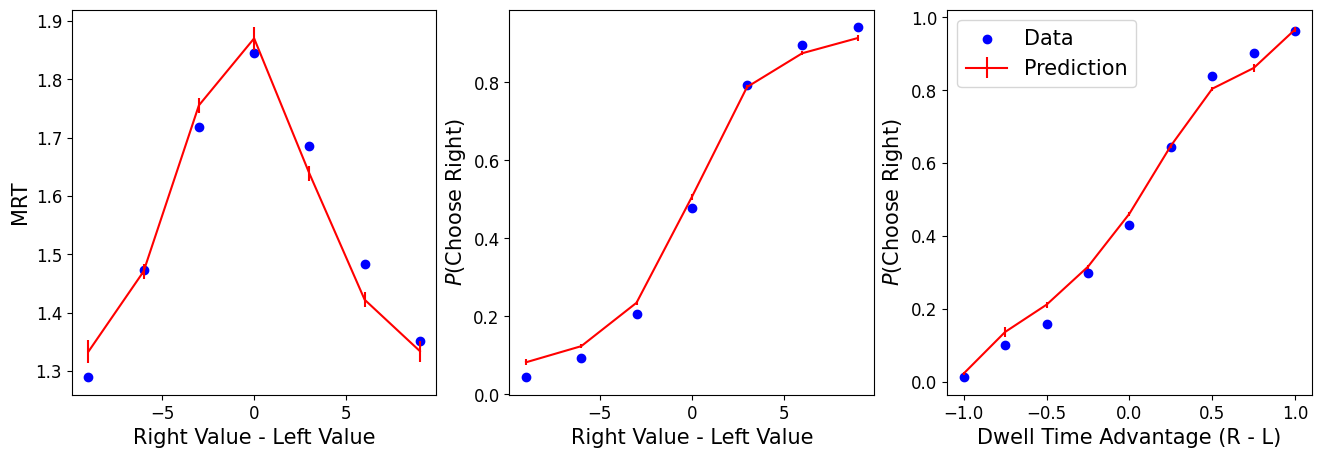

In [12]:
plt.figure(figsize=(16, 5))
plt.subplot(131)
se = pred_bhv.groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(pred_bhv.groupby(by='value_diff')['value_diff'].mean(),
             pred_bhv.groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red')
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(132)
se = pred_bhv.groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv.groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(133)
se = pred_bhv.groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(),
             y=pred_bhv.groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), 
            c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose Right)');
plt.legend();

plt.savefig('_plots/tv2017_splitted_postpred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');

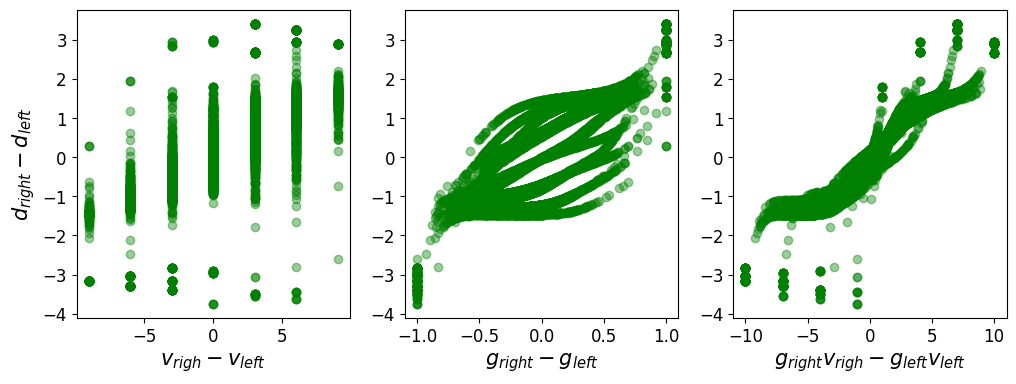

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 1] - X_test[:, 0], 
            pred_v[:, 1] - pred_v[:, 0], alpha=0.4, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');
plt.xlabel(r'$v_{righ} - v_{left}$ ');

plt.subplot(132)
plt.scatter(X_test[:, 3] - X_test[:, 2], 
            pred_v[:, 1] - pred_v[:, 0], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(133)
plt.scatter(X_test[:, 1]*X_test[:, 3] - X_test[:, 0]*X_test[:, 2], 
            pred_v[:, 1] - pred_v[:, 0], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/tv2017_splitted_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');